In [1]:
import os
print(os.listdir('../input'))

['brain-tumor-classification-mri']


In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt 
import matplotlib.colors
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix 
import tensorflow as tf 
from tensorflow import keras
from tqdm import tqdm 
from sklearn.utils import shuffle 
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import ConfusionMatrixDisplay


2024-09-07 11:01:41.598868: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 11:01:41.598995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 11:01:41.736292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
X_train =[]
Y_train =[] 
image_size =150 
for i in labels : 
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))  
        img = cv2.resize(img,(image_size,image_size))
        img = img / 255.0  # Normalize the image
        X_train.append(img) 
        Y_train.append(i)

for i in labels : 
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))  
        img = cv2.resize(img,(image_size,image_size))
        img = img / 255.0  # Normalize the image
        X_train.append(img) 
        Y_train.append(i) 
X_train = np.array(X_train) 
Y_train = np.array(Y_train)
		

100%|██████████| 74/74 [00:00<00:00, 109.96it/s]


In [4]:
X_train , Y_train = shuffle(X_train ,Y_train,random_state=101)

In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train, test_size=0.1,random_state=101)

In [6]:
# Reshape the 4D arrays to 2D
num_samples_train = X_train.shape[0]
num_samples_test = X_test.shape[0]

X_train_reshaped = X_train.reshape(num_samples_train, -1)  # Flatten images
X_test_reshaped = X_test.reshape(num_samples_test, -1)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.98)
pca_train = pca.fit_transform(X_train_reshaped)
pca_test = pca.transform(X_test_reshaped)


In [7]:
# Apply SMOTE on the PCA-transformed data
smote = SMOTE()
X_resampled, Y_resampled = smote.fit_resample(pca_train, Y_train)

print(X_resampled.shape)
print(Y_resampled.shape)


(3364, 1348)
(3364,)


In [8]:
from collections import Counter
train_class_counts = Counter(Y_train)
resampled_class_counts = Counter(Y_resampled)

print("Original training class distribution:", train_class_counts)
print("Resampled class distribution:", resampled_class_counts)

Original training class distribution: Counter({'meningioma_tumor': 841, 'glioma_tumor': 833, 'pituitary_tumor': 814, 'no_tumor': 449})
Resampled class distribution: Counter({'glioma_tumor': 841, 'no_tumor': 841, 'pituitary_tumor': 841, 'meningioma_tumor': 841})


In [9]:


 #Define the parameter grid for hyperparameter tuning
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [1, 10],
    'gamma': ['scale', 'auto']}

 #Create an instance of the SVC
svc = SVC()

 #Initialize GridSearchCV with the SVC model and the parameter grid
clf = GridSearchCV(svc, param_grid, cv=5, verbose=2)  # 5-fold cross-validation

# Perform the grid search on the training data
clf.fit(X_resampled, Y_resampled)

# Get the best parameters and best score from the grid search
best_params = clf.best_params_
best_score = clf.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best cross-validation score: {best_score}")
#svc.fit(X_resampled, Y_resampled)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   2.8s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   2.8s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   2.7s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   2.9s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   2.9s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   4.2s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   4.2s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   4.4s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   4.4s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   4.5s
[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   2.8s
[CV] END .....................C=1, gamma=auto, ke

In [10]:
# Evaluate the best model on the test set
best_model = clf.best_estimator_
test_score = best_model.score(pca_test, Y_test)
print("Testing Score:", test_score)

Testing Score: 0.9051987767584098


In [11]:
# Calculate accuracy on training and validation sets
train_accuracy = best_model.score(X_resampled, Y_resampled)


In [12]:
print("Training Score:", train_accuracy)


Training Score: 0.9994054696789536


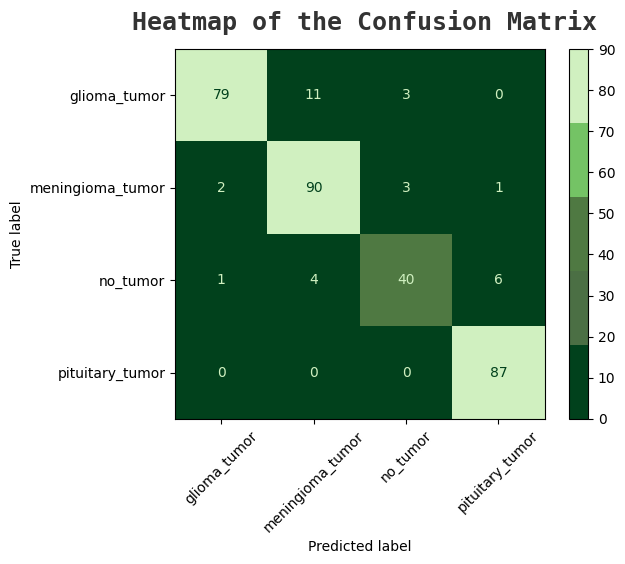

In [13]:

# Predict the response for test dataset
y_pred = best_model.predict(pca_test)

# Define the custom color map
custom_colors = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
custom_cmap = matplotlib.colors.ListedColormap(custom_colors)

# Calculate confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Create a display object with the custom color map
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

# Plot the confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap=custom_cmap, ax=ax)

# Set the title and axis labels
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.10,alpha=0.8)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Save the figure
plt.savefig('CM SVM.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [14]:

# Additional evaluations
y_pred = best_model.predict(pca_test)
conf_matrix = confusion_matrix(Y_test, y_pred)
class_report = classification_report(Y_test, y_pred)

print("Testing Score:", test_score)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)



Testing Score: 0.9051987767584098
Confusion Matrix:
 [[79 11  3  0]
 [ 2 90  3  1]
 [ 1  4 40  6]
 [ 0  0  0 87]]
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.96      0.85      0.90        93
meningioma_tumor       0.86      0.94      0.90        96
        no_tumor       0.87      0.78      0.82        51
 pituitary_tumor       0.93      1.00      0.96        87

        accuracy                           0.91       327
       macro avg       0.90      0.89      0.90       327
    weighted avg       0.91      0.91      0.90       327

